### Notebook: Visualizing Time Independent Models

30 May 2024

Objectives:
- Troubleshoot age issue
- Further work on feature selection and cross-validation
- Analysis and visuals


In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error

# ------------------------------------------------
from catboost import CatBoostClassifier, Pool, MetricVisualizer


# ------------------------------------------------

data_path = "../../main_data/locale_specific_data/"

In [3]:
dog_df = pd.read_csv(data_path + "Sonoma_time_independent_data_akry.csv")

dog_df.head()

,breed,color,sex,size,date_of_birth,animal_id,intake_date,outcome_date,days_in_shelter,intake_type,...,outcome_adopt,outcome_adopt_subtype,intake_age,outcome_age,pop_control,sex_bin,size_bin,breed_pit,color_mix,intake_bin
0,PIT BULL,GRAY/WHITE,Female,MED,2012-09-03,A296009,2013-08-22,2014-04-14,235,TRANSFER,...,False,none,0.97,1.61,1,1,3,1,1,4
1,PIT BULL,BLUE/WHITE,Female,MED,2012-10-09,A294143,2013-08-31,2014-04-14,226,STRAY,...,False,none,0.89,1.51,1,1,3,1,1,0
2,CAROLINA DOG/MIX,GOLD/WHITE,Male,MED,2007-09-07,A281788,2013-09-19,2014-07-30,314,STRAY,...,False,none,6.03,6.90,0,0,3,0,1,0
3,CHIHUAHUA SH,TAN,Male,TOY,2007-10-01,A297574,2013-10-01,2014-01-01,92,OWNER SURRENDER,...,False,none,6.00,6.25,1,0,1,0,0,1
4,PIT BULL,TAN/WHITE,Male,MED,2012-10-29,A298002,2013-10-08,2014-05-22,226,STRAY,...,True,realtime,0.95,1.57,1,0,3,1,1,0


In [4]:
dog_df.columns

Index(['breed', 'color', 'sex', 'size', 'date_of_birth', 'animal_id',
       'intake_date', 'outcome_date', 'days_in_shelter', 'intake_type',
       'intake_subtype', 'outcome_type', 'outcome_subtype', 'intake_condition',
       'outcome_condition', 'dob_season', 'intake_season', 'outcome_season',
       'outcome_adopt', 'outcome_adopt_subtype', 'intake_age', 'outcome_age',
       'pop_control', 'sex_bin', 'size_bin', 'breed_pit', 'color_mix',
       'intake_bin'],
      dtype='object')

## 0. Check Ages

In [6]:
dog_df['intake_age'].value_counts().sort_index()

intake_age
-1.94     1
-0.76     1
-0.52     1
-0.23     1
-0.08     1
         ..
 17.00    1
 17.13    1
 18.00    1
 19.00    2
 20.99    1
Name: count, Length: 1256, dtype: int64

In [16]:
nonpos_age_df = dog_df[dog_df['intake_age'] <= 0]
nonpos_age_df = nonpos_age_df[['size', 'date_of_birth', 'intake_date']]
nonpos_age_df['size'].value_counts()

size
PUPPY    66
TOY       4
MED       2
X-LRG     1
Name: count, dtype: int64

## 1. CatBoost Modeling

### Create train-test split 

In [18]:
X_train, X_hold, y_train, y_hold = train_test_split(dog_df,
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2,
                                      random_state=1342)

### Model creation

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Confusion Matrix for training set:
 [[2007  326]
 [  66 2805]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    19.717425
1        intake_age    13.777360
2             color    12.017129
3             breed    12.001552
4  intake_condition    10.651541
5              size    10.377559
6    outcome_season     8.220443
7       intake_type     7.255286
8               sex     5.981704
Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.86      0.91      2333
        True       0.90      0.98      0.93      2871

    accuracy                           0.92      5204
   macro avg       0.93      0.92      0.92      5204
weighted avg       0.93      0.92      0.92      5204



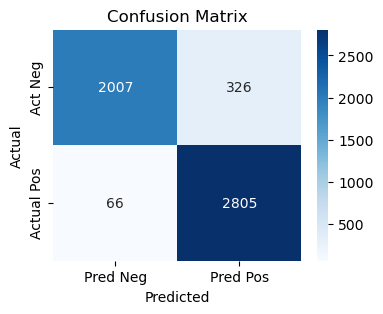

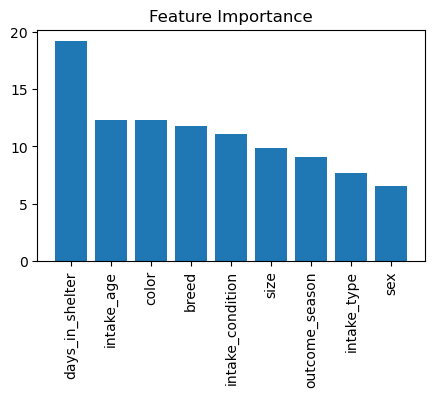

In [61]:
feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="MultiClass", depth=tree_depth).fit(pool, eval_set=(X_t, y_t), verbose=False, plot=True)
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix for training set:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

plt.figure(figsize=(4, 3))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
            'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

feat_arry = np.array(feature_list)
importances = clf.get_feature_importance()
sorted_indices = np.argsort(importances)[::-1] 
plt.figure(figsize=(5, 3))
plt.bar(range(len(feature_list)), importances[sorted_indices])
plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.show()

del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, feat_arry, importances, sorted_indices



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Confusion Matrix for training set:
 [[2047  286]
 [  49 2822]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    19.164922
1        intake_age    15.414941
2             breed    12.725534
3             color    11.557784
4  intake_condition     9.875424
5              size     9.260936
6    outcome_season     8.052521
7       intake_type     8.048518
8               sex     5.899420
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.88      0.92      2333
        True       0.91      0.98      0.94      2871

    accuracy                           0.94      5204
   macro avg       0.94      0.93      0.93      5204
weighted avg       0.94      0.94      0.94      5204



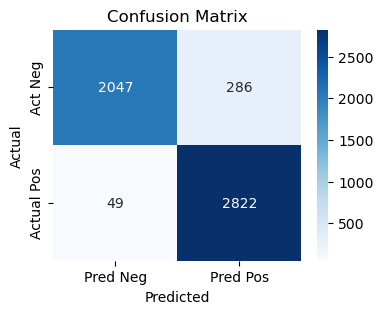

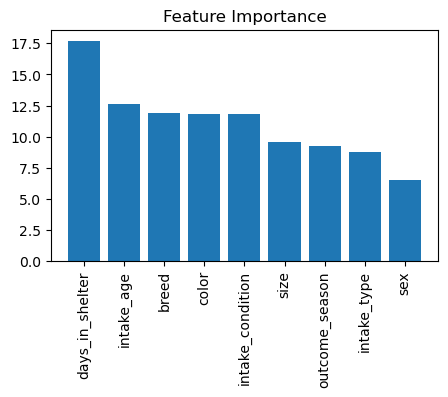

In [62]:
feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="CrossEntropy", depth=tree_depth).fit(pool, eval_set=(X_t, y_t), verbose=False, plot=True)
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix for training set:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

plt.figure(figsize=(4, 3))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
            'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

feat_arry = np.array(feature_list)
importances = clf.get_feature_importance()
sorted_indices = np.argsort(importances)[::-1] 
plt.figure(figsize=(5, 3))
plt.bar(range(len(feature_list)), importances[sorted_indices])
plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.show()

del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, feat_arry, importances, sorted_indices


In [43]:
feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth).fit(pool, eval_set=(X_t, y_t), verbose=False, plot=True)
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))
print('Confusion Matrix for training set:\n', confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t)))
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print('Model params:')
print(clf.get_params())

del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Confusion Matrix for training set:
 [[2047  286]
 [  49 2822]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    19.164922
1        intake_age    15.414941
2             breed    12.725534
3             color    11.557784
4  intake_condition     9.875424
5              size     9.260936
6    outcome_season     8.052521
7       intake_type     8.048518
8               sex     5.899420
Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Confusion Matrix for training set:
 [[1897  436]
 [ 115 2756]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    18.430505
1        intake_age    16.612831
2  intake_condition    16.010093
3             breed    10.367968
4              size    10.118131
5       intake_type     8.185297
6    outcome_season     8.102002
7             color     7.831898
8               sex     4.341274

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.81      0.87      2333
        True       0.86      0.96      0.91      2871

    accuracy                           0.89      5204
   macro avg       0.90      0.89      0.89      5204
weighted avg       0.90      0.89      0.89      5204



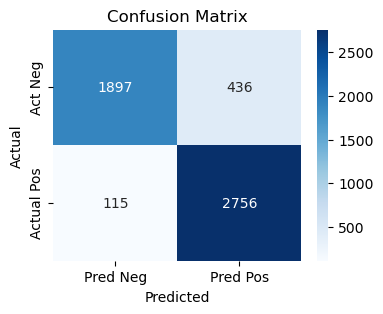

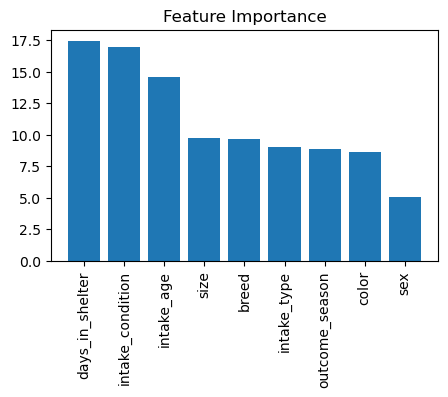

In [63]:
feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
lrn_rate = 0.03
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="MultiClass", depth=tree_depth).fit(pool, eval_set=(X_t, y_t), verbose=False, plot=True)
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))
confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix for training set:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

plt.figure(figsize=(4, 3))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
            'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

feat_arry = np.array(feature_list)
importances = clf.get_feature_importance()
sorted_indices = np.argsort(importances)[::-1] 
plt.figure(figsize=(5, 3))
plt.bar(range(len(feature_list)), importances[sorted_indices])
plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.show()

del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, feat_arry, importances, sorted_indices




In [68]:
feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type',
                # 'outcome_adopt_subtype'
                ]
tree_depth = 6
cv_splits  = 9

kfold  = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1342)
scores = pd.DataFrame(columns=['accuracy','tree_count'], index=range(cv_splits))

i = 0
for t_idx, h_idx in kfold.split(X_train, X_train.outcome_adopt):
    X_t = dog_df[feature_list].iloc[t_idx]
    X_t = X_t.astype(str)
    y_t = dog_df.outcome_adopt.iloc[t_idx]
    X_h = dog_df[feature_list].iloc[h_idx]
    X_h = X_h.astype(str)
    y_h = dog_df.outcome_adopt.iloc[h_idx]

    pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)

    clf  = CatBoostClassifier(iterations=1000, learning_rate=0.1, loss_function="MultiClass", depth=tree_depth, task_type="CPU").fit(pool, eval_set=(X_h, y_h), verbose=False)
    train_dir= i
    scores.loc[i, "tree_count"] = clf.tree_count_
    scores.loc[i, "accuracy"]   = accuracy_score(y_true = y_h, y_pred = clf.predict(X_h))
    print()
    print(confusion_matrix(y_true = y_h, y_pred = clf.predict(X_h)))
    print()
    print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
    print(classification_report(y_true = y_h, y_pred = clf.predict(X_h)))
    print()
    del clf, pool   
    del X_t, y_t, X_h, y_h
    i+=1
    print('-'*50)




[[147  98]
 [ 36 298]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    16.493217
1        intake_age    15.224934
2  intake_condition    14.844015
3             breed    12.528064
4              size    11.744615
5             color     9.056091
6       intake_type     7.704861
7               sex     7.098022
8    outcome_season     5.306181
              precision    recall  f1-score   support

       False       0.80      0.60      0.69       245
        True       0.75      0.89      0.82       334

    accuracy                           0.77       579
   macro avg       0.78      0.75      0.75       579
weighted avg       0.77      0.77      0.76       579


--------------------------------------------------

[[155  92]
 [ 37 295]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition    23.138714
1   days_in_shelter    16.284575
2        intake_age    15.947286
3      